Importing all the functions and libaries

In [1]:
from sklift.datasets import fetch_hillstrom
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklift.metrics import uplift_at_k
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklift.models import TwoModels
import shap

## Loading the Dataset 
 1. We first fetch the dataset from the sklift librabry in python.
 2. Then we display the first two rows.

In [2]:
dataset = fetch_hillstrom(target_col='visit', return_X_y_t=False)
df = pd.DataFrame(dataset.data)
df['target'] = dataset.target
df['treatment'] = dataset.treatment

print(df.head())

   recency history_segment  history  mens  womens   zip_code  newbie channel  \
0       10  2) $100 - $200   142.44     1       0  Surburban       0   Phone   
1        6  3) $200 - $350   329.08     1       1      Rural       1     Web   
2        7  2) $100 - $200   180.65     0       1  Surburban       1     Web   
3        9  5) $500 - $750   675.83     1       0      Rural       1     Web   
4        2    1) $0 - $100    45.34     1       0      Urban       0     Web   

   target      treatment  
0       0  Womens E-Mail  
1       0      No E-Mail  
2       0  Womens E-Mail  
3       0    Mens E-Mail  
4       0  Womens E-Mail  


## Information about the Dataset

In [3]:
print(df.info())

print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  object 
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  object 
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  object 
 8   target           64000 non-null  int64  
 9   treatment        64000 non-null  object 
dtypes: float64(1), int64(5), object(4)
memory usage: 4.9+ MB
None
            recency       history          mens        womens        newbie  \
count  64000.000000  64000.000000  64000.000000  64000.000000  64000.000000   
mean       5.763734    242.085656      0.551031      0.549719      0.502250   
std        3.507592    256.158608  

# Plotting the Target and Treatment distribution
Note that here the target variable chosen is 'Visits'.

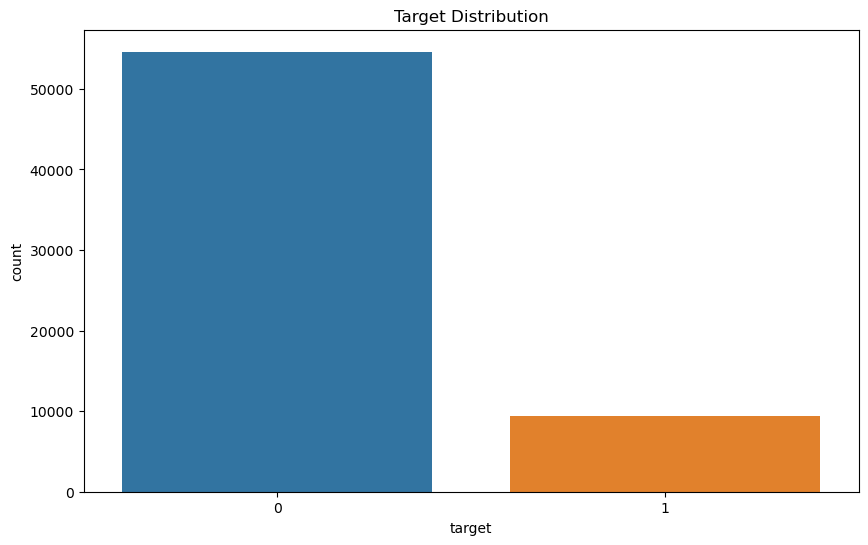

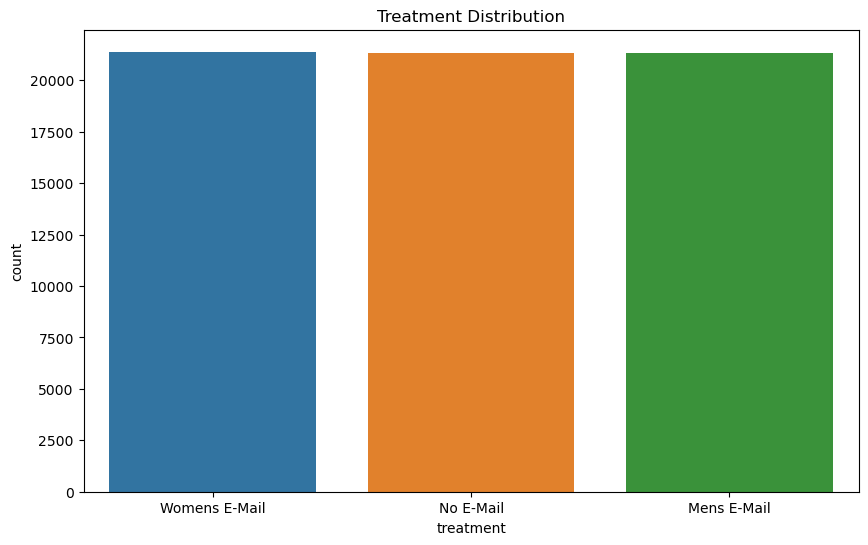

In [4]:
# Plot target distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=df)
plt.title('Target Distribution')
plt.show()

# Plot treatment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='treatment', data=df)
plt.title('Treatment Distribution')
plt.show()

## Plotting the target distribution by treatment group

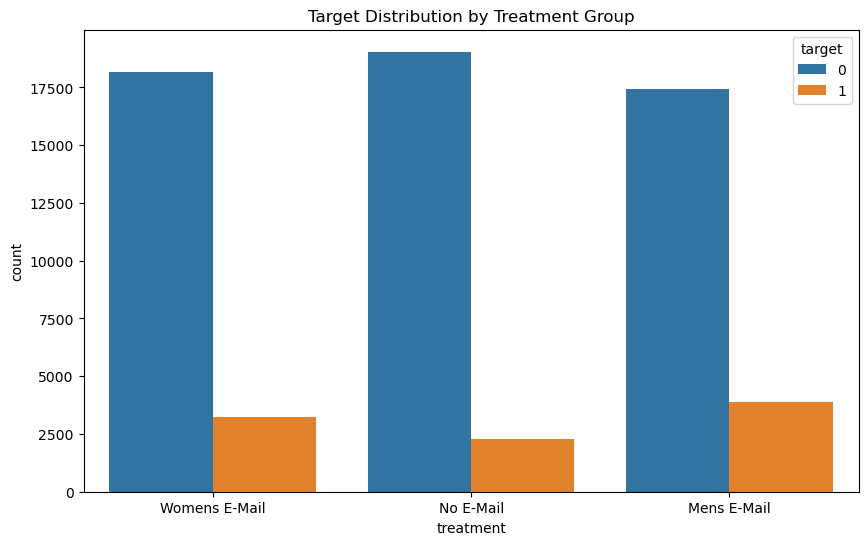

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(x='treatment', hue='target', data=df)
plt.title('Target Distribution by Treatment Group')
plt.show()

## Filtering data for Men's and Women's email campaigns
We also give a summary of the statistics described for said individual groups

In [6]:
df_mens = df[df['treatment'] == 'Mens E-Mail']
df_womens = df[df['treatment'] == 'Womens E-Mail']

print("Men's Email Campaign:")
print(df_mens.describe())

print("Women's Email Campaign:")
print(df_womens.describe())

Men's Email Campaign:
            recency       history          mens        womens        newbie  \
count  21307.000000  21307.000000  21307.000000  21307.000000  21307.000000   
mean       5.773642    242.835931      0.550946      0.551415      0.501525   
std        3.513350    260.355685      0.497409      0.497361      0.500009   
min        1.000000     29.990000      0.000000      0.000000      0.000000   
25%        2.000000     63.580000      0.000000      0.000000      0.000000   
50%        6.000000    157.220000      1.000000      1.000000      1.000000   
75%        9.000000    325.215000      1.000000      1.000000      1.000000   
max       12.000000   3215.970000      1.000000      1.000000      1.000000   

             target  
count  21307.000000  
mean       0.182757  
std        0.386476  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  
Women's Email Campaign:
            recency       history          m

## Converting string values to numerical values
Here the treatment variable is assigned numerical values. It makes the data processing easier while implementing the models

In [7]:
df['treatment'] = df['treatment'].map({'No E-Mail': 0, 'Mens E-Mail': 1, 'Womens E-Mail': 2})

One-hot encoding categorical variables

In [8]:
df = pd.get_dummies(df, columns=['history_segment', 'zip_code', 'channel'], drop_first=True)

### Splitting the Data into training and testing sets

In [9]:
X = df.drop(columns=['target', 'treatment'])
y = df['target']
t = df['treatment']
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(X, y, t, test_size=0.2, random_state=42)

# The Single Learner Model (XG-Boost Classifier)
1. We implement the model and get its uplift score
2. Then we plot a graph to compare the men's and women's uplift score.
3. Then we draw a feature importance plot to explore the key attributes that affect this model the most.

In [10]:
def single_learner_uplift(X_train, y_train, T_train, X_test, y_test, T_test):
    # Combine the training data with the treatment variable
    X_train_single = np.hstack((X_train, T_train.values.reshape(-1, 1)))
    X_test_single = np.hstack((X_test, T_test.values.reshape(-1, 1)))
    
    # Initialize and fit the XGBoost model
    model_single = xgb.XGBClassifier(n_estimators=100, random_state=42)
    model_single.fit(X_train_single, y_train)

    # Prepare test data for different treatments
    X_test_no_email = np.hstack((X_test, np.zeros((X_test.shape[0], 1))))
    X_test_mens = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
    X_test_womens = np.hstack((X_test, np.full((X_test.shape[0], 1), 2)))
    
    # Predict probabilities
    no_email_preds = model_single.predict_proba(X_test_no_email)[:, 1]
    mens_preds = model_single.predict_proba(X_test_mens)[:, 1]
    womens_preds = model_single.predict_proba(X_test_womens)[:, 1]
    
    # Calculate uplift scores
    uplift_scores_mens = mens_preds - no_email_preds
    uplift_scores_womens = womens_preds - no_email_preds
    
    # Evaluate uplift model
    uplift_score_mens = uplift_at_k(y_test, uplift_scores_mens, treatment=T_test == 1, strategy='overall', k=0.3)
    uplift_score_womens = uplift_at_k(y_test, uplift_scores_womens, treatment=T_test == 2, strategy='overall', k=0.3)
    
    # Return the model, uplift scores, and test data variations
    return model_single, uplift_scores_mens, uplift_score_mens, uplift_scores_womens, uplift_score_womens, X_test_no_email, X_test_mens, X_test_womens

# Call the function and get the outputs
model_single, uplift_scores_single_mens, uplift_score_single_mens, uplift_scores_single_womens, uplift_score_single_womens, X_test_no_email, X_test_mens, X_test_womens = single_learner_uplift(X_train, y_train, T_train, X_test, y_test, T_test)

print(f'Single-Learner XGBoost Uplift for Men\'s at 30%: {uplift_score_single_mens}')
print(f'Single-Learner XGBoost Uplift for Women\'s at 30%: {uplift_score_single_womens}')

Single-Learner XGBoost Uplift for Men's at 30%: 0.0580377027745449
Single-Learner XGBoost Uplift for Women's at 30%: 0.03766764636329853


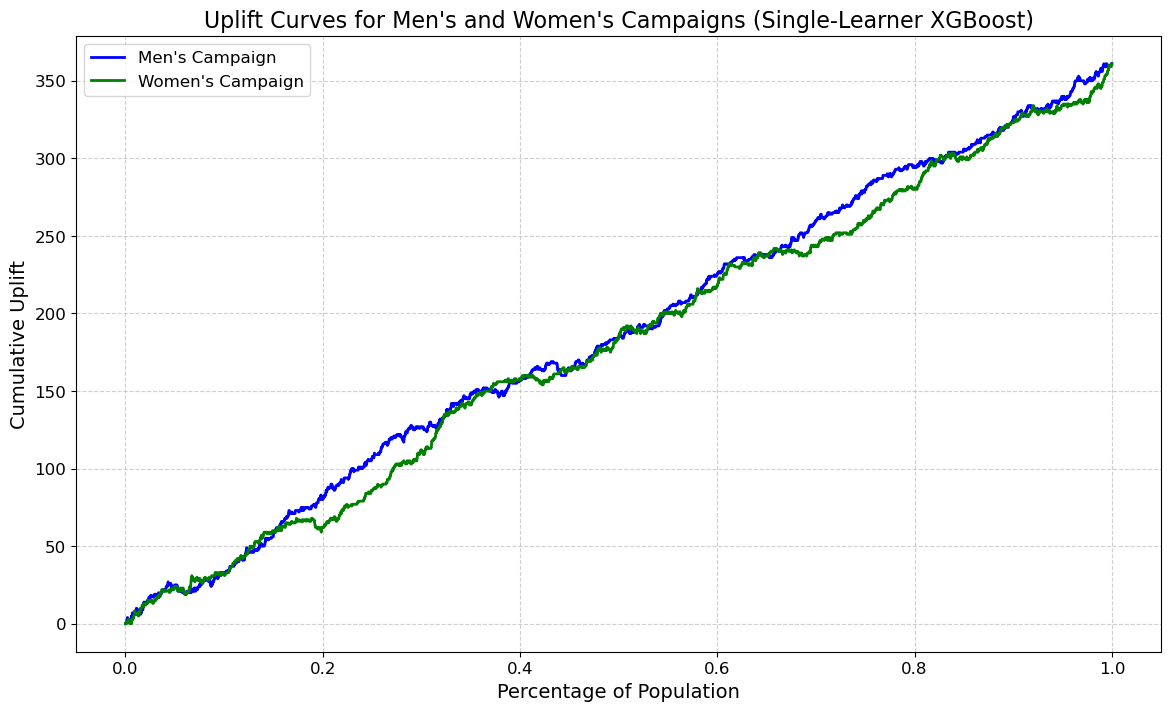

In [11]:
def plot_single_learner_uplift(y_test, T_test, uplift_scores_single_mens, uplift_scores_single_womens):
    y_test = np.array(y_test)
    T_test = np.array(T_test)
    
    def cumulative_uplift(y_true, uplift_scores, treatment):
        sorted_indices = np.argsort(uplift_scores)[::-1]
        y_true_sorted = y_true[sorted_indices]
        treatment_sorted = treatment[sorted_indices]
        cumulative_uplift = np.cumsum(y_true_sorted * (treatment_sorted == 1)) - np.cumsum(y_true_sorted * (treatment_sorted == 0))
        return cumulative_uplift

    cumulative_uplift_mens = cumulative_uplift(y_test, uplift_scores_single_mens, T_test)
    cumulative_uplift_womens = cumulative_uplift(y_test, uplift_scores_single_womens, T_test)
    
    plt.figure(figsize=(14, 8))
    plt.plot(np.arange(len(cumulative_uplift_mens)) / len(cumulative_uplift_mens), cumulative_uplift_mens, label="Men's Campaign", color='blue', linewidth=2)
    plt.plot(np.arange(len(cumulative_uplift_womens)) / len(cumulative_uplift_womens), cumulative_uplift_womens, label="Women's Campaign", color='green', linewidth=2)
    plt.title('Uplift Curves for Men\'s and Women\'s Campaigns (Single-Learner XGBoost)', fontsize=16)
    plt.xlabel('Percentage of Population', fontsize=14)
    plt.ylabel('Cumulative Uplift', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

plot_single_learner_uplift(y_test, T_test, uplift_scores_single_mens, uplift_scores_single_womens)


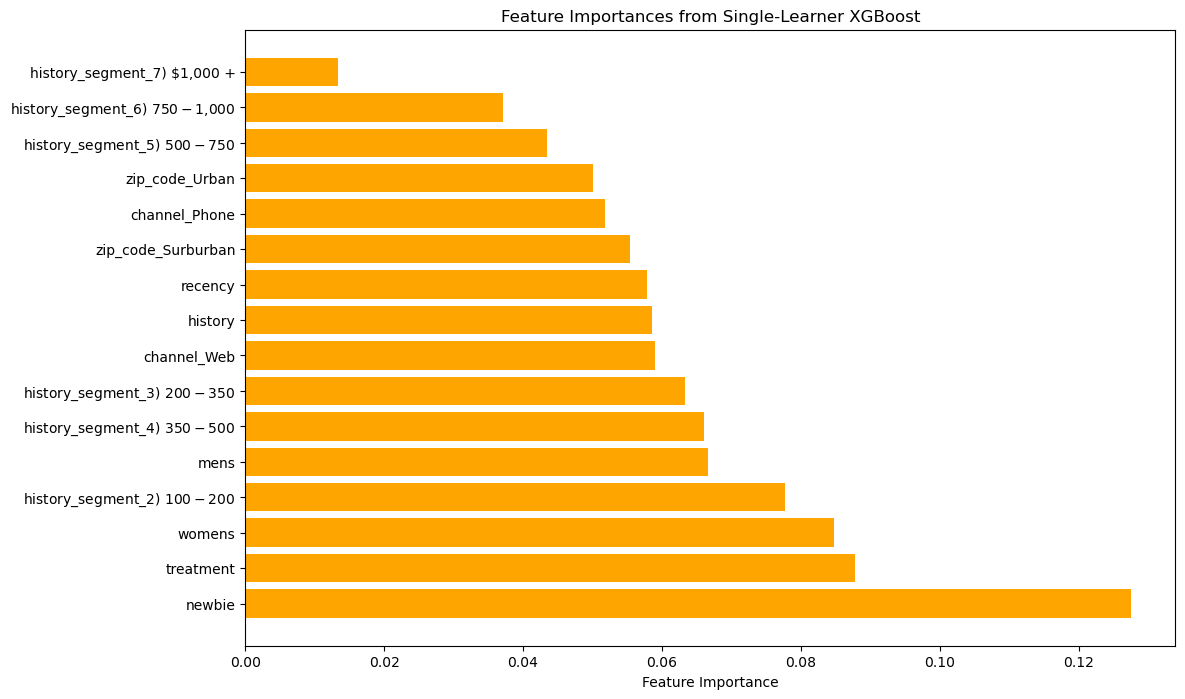

In [12]:
feature_importances_single = model_single.feature_importances_
feature_names_single = list(X_train.columns) + ['treatment']

indices_single = np.argsort(feature_importances_single)[::-1]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_names_single)), feature_importances_single[indices_single], align="center", color='orange')
plt.yticks(range(len(feature_names_single)), np.array(feature_names_single)[indices_single])
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Single-Learner XGBoost')
plt.show()

## Implementing Shap Values (for better Explanability)
How to Read a SHAP Summary Plot

A SHAP summary plot gives understanding about how each feature helps make the model's predictions:

<b> Vertical Axis: </b> Shows the features ordered by importance. Most significant ones are at the top.

<b> Horizontal Position: </b> Shows the SHAP value, which tells how much it changes prediction. Values on right side increase prediction, while values on left side decrease it.

<b> Color: </b> It shows the feature value. For example, red means high values and blue means low values. This is useful to understand how feature values affect predictions.

For example, if a feature's red points (high values) mostly appear on the right side, this suggests that higher values of that feature make the prediction go up.

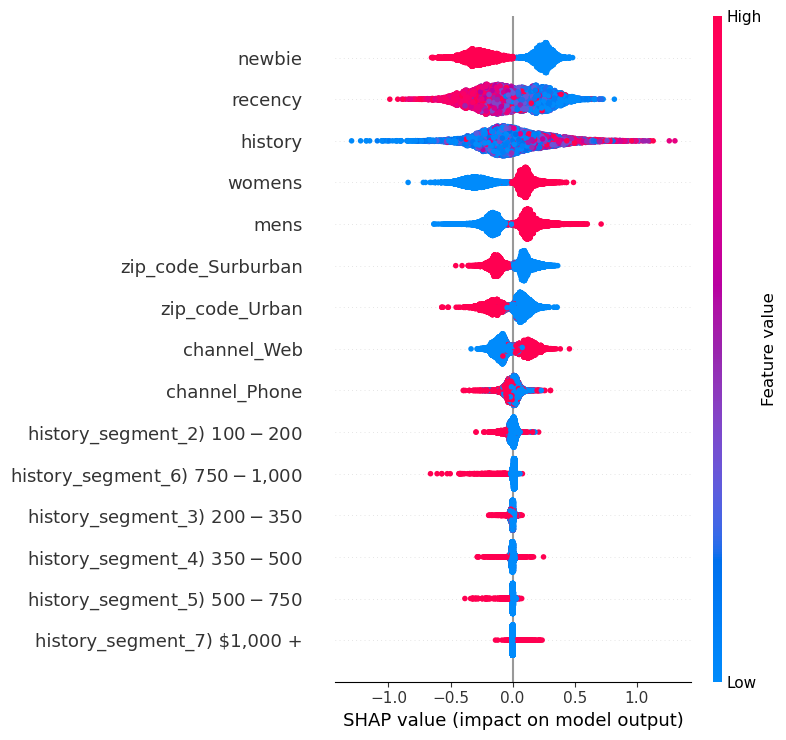

In [13]:
explainer_single = shap.TreeExplainer(model_single)

shap_values_mens = explainer_single.shap_values(X_test_mens)

shap_values_mens = shap_values_mens[:, :-1]

shap.summary_plot(shap_values_mens, X_test_mens[:, :-1], feature_names=X.columns)


## How to Read a SHAP Dependency Plot

A SHAP dependency plot is a graph that shows how one feature influences the model’s predictions, while also considering interactions with other features. It helps to understand if a particular feature has a big or small effect on what the model predicts and how this might change when mixed with other features.

<b> Vertical Axis: </b> It shows the SHAP value for the feature, indicating how much it affects the prediction.

<b> Horizontal Axis: </b> Represents the actual feature values.

<b> Color: </b> Shows the value of another feature that works with the main feature being looked at (usually, it is the most interacting one).

For example, you can see how feature's value affect predictions and its interaction with other feature.

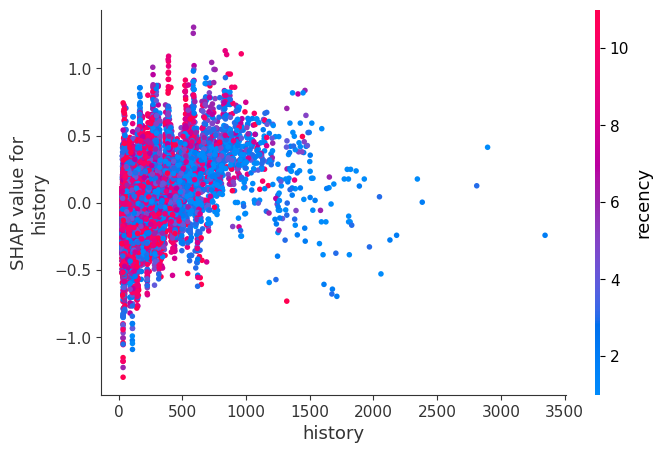

In [14]:
# Choose a feature to analyze, for example, 'recency'
feature_name = 'history'

shap.dependence_plot(feature_name, shap_values_mens, X_test_mens[:, :-1], feature_names=X.columns)

# sklift Two-Model Classifier (Random Forest Classifier)
1. We implement the model and get its uplift score
2. Then we plot a graph to compare the men's and women's uplift score.
3. Then we draw a feature importance plot to explore the key attributes that affect this model the most.

In [15]:
def uplift_rf_two_models(X_train, y_train, T_train, X_test, y_test, T_test, treatment_value):
    is_treatment = (T_train == treatment_value).astype(int)
    
    uplift_model = TwoModels(
        estimator_trmnt=RandomForestClassifier(n_estimators=100, random_state=42),
        estimator_ctrl=RandomForestClassifier(n_estimators=100, random_state=42)
    )
    uplift_model.fit(X_train, y_train, is_treatment)

    uplift_scores = uplift_model.predict(X_test)

    is_treatment_test = (T_test == treatment_value).astype(int)
    uplift_score = uplift_at_k(y_test, uplift_scores, treatment=is_treatment_test, strategy='overall', k=0.3)
    
    return uplift_model, uplift_scores, uplift_score

model_mens_rf, uplift_scores_mens_rf, uplift_score_mens_rf = uplift_rf_two_models(X_train, y_train, T_train, X_test, y_test, T_test, treatment_value=1)
model_womens_rf, uplift_scores_womens_rf, uplift_score_womens_rf = uplift_rf_two_models(X_train, y_train, T_train, X_test, y_test, T_test, treatment_value=2)

print(f'Uplift TwoModels Random Forest for Men\'s at 30%: {uplift_score_mens_rf}')
print(f'Uplift TwoModels Random Forest for Women\'s at 30%: {uplift_score_womens_rf}')

Uplift TwoModels Random Forest for Men's at 30%: 0.062371507307376395
Uplift TwoModels Random Forest for Women's at 30%: 0.016159821312893535


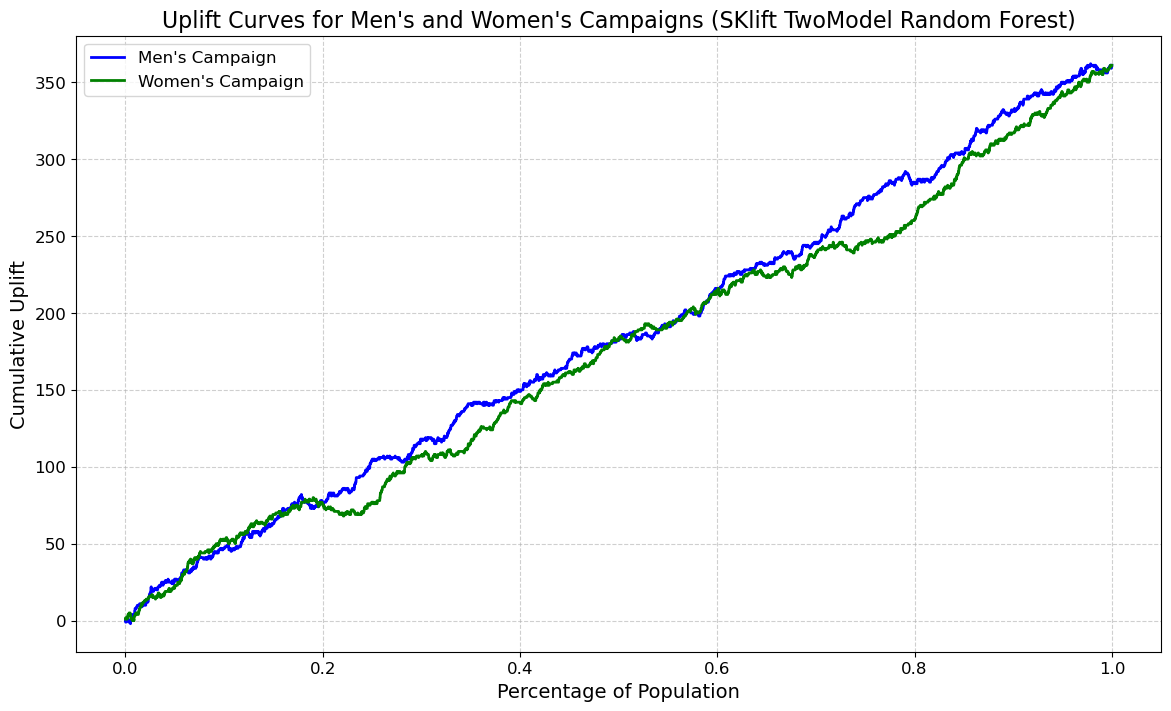

In [16]:
def plot_uplift_curves(y_test, T_test, uplift_scores_mens, uplift_scores_womens):
    y_test = np.array(y_test)
    T_test = np.array(T_test)
    
    def cumulative_uplift(y_true, uplift_scores, treatment):
        sorted_indices = np.argsort(uplift_scores)[::-1]
        y_true_sorted = y_true[sorted_indices]
        treatment_sorted = treatment[sorted_indices]
        cumulative_uplift = np.cumsum(y_true_sorted * (treatment_sorted == 1)) - np.cumsum(y_true_sorted * (treatment_sorted == 0))
        return cumulative_uplift

    cumulative_uplift_mens = cumulative_uplift(y_test, uplift_scores_mens, T_test)
    cumulative_uplift_womens = cumulative_uplift(y_test, uplift_scores_womens, T_test)
    
    plt.figure(figsize=(14, 8))
    plt.plot(np.arange(len(cumulative_uplift_mens)) / len(cumulative_uplift_mens), cumulative_uplift_mens, label="Men's Campaign", color='blue', linewidth=2)
    plt.plot(np.arange(len(cumulative_uplift_womens)) / len(cumulative_uplift_womens), cumulative_uplift_womens, label="Women's Campaign", color='green', linewidth=2)
    plt.title('Uplift Curves for Men\'s and Women\'s Campaigns (SKlift TwoModel Random Forest)', fontsize=16)
    plt.xlabel('Percentage of Population', fontsize=14)
    plt.ylabel('Cumulative Uplift', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

plot_uplift_curves(y_test, T_test, uplift_scores_mens_rf, uplift_scores_womens_rf)


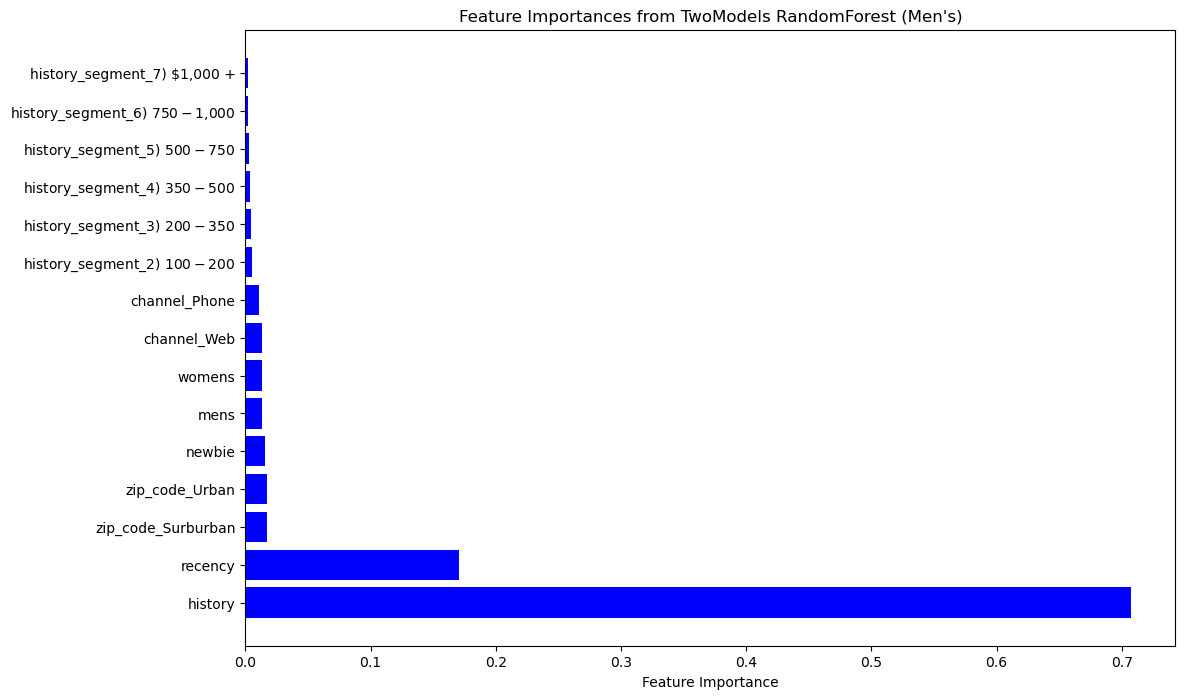

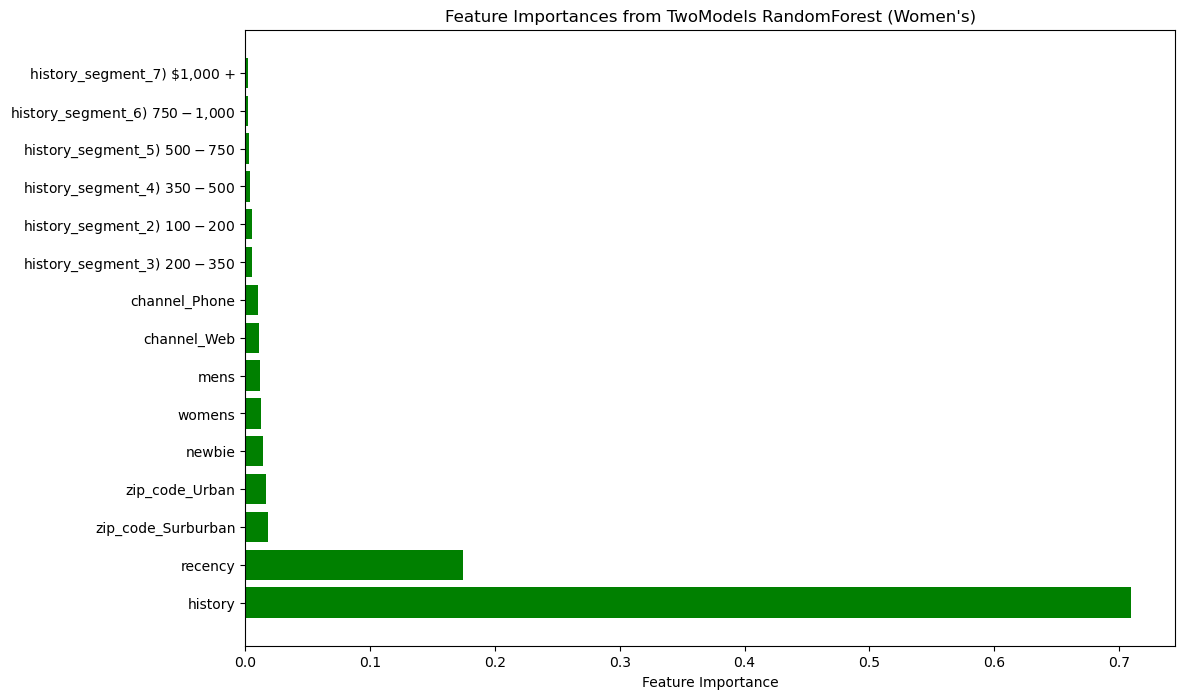

In [17]:
feature_importances_mens_rf = model_mens_rf.estimator_trmnt.feature_importances_
feature_names_rf = X_train.columns

indices_mens_rf = np.argsort(feature_importances_mens_rf)[::-1]

plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_names_rf)), feature_importances_mens_rf[indices_mens_rf], align="center", color='blue')
plt.yticks(range(len(feature_names_rf)), np.array(feature_names_rf)[indices_mens_rf])
plt.xlabel('Feature Importance')
plt.title('Feature Importances from TwoModels RandomForest (Men\'s)')
plt.show()

feature_importances_womens_rf = model_womens_rf.estimator_trmnt.feature_importances_
indices_womens_rf = np.argsort(feature_importances_womens_rf)[::-1]

plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_names_rf)), feature_importances_womens_rf[indices_womens_rf], align="center", color='green')
plt.yticks(range(len(feature_names_rf)), np.array(feature_names_rf)[indices_womens_rf])
plt.xlabel('Feature Importance')
plt.title('Feature Importances from TwoModels RandomForest (Women\'s)')
plt.show()

# Custom Two-Model Classifier (Our Best Performer)
1. We implement the model and get its uplift score
2. Then we plot a graph to compare the men's and women's uplift score.
3. Then we draw a feature importance plot to explore the key attributes that affect this model the most.

In [18]:
def two_model_classifier(X_train, y_train, T_train, X_test, y_test, T_test):
    X_train_mens = X_train[T_train == 1]
    y_train_mens = y_train[T_train == 1]
    X_train_control_mens = X_train[T_train == 0]
    y_train_control_mens = y_train[T_train == 0]
    
    X_train_womens = X_train[T_train == 2]
    y_train_womens = y_train[T_train == 2]
    X_train_control_womens = X_train[T_train == 0]
    y_train_control_womens = y_train[T_train == 0]

    model_treatment_mens = RandomForestClassifier(n_estimators=100, random_state=42)
    model_control_mens = RandomForestClassifier(n_estimators=100, random_state=42)

    model_treatment_mens.fit(X_train_mens, y_train_mens)
    model_control_mens.fit(X_train_control_mens, y_train_control_mens)

    model_treatment_womens = RandomForestClassifier(n_estimators=100, random_state=42)
    model_control_womens = RandomForestClassifier(n_estimators=100, random_state=42)

    model_treatment_womens.fit(X_train_womens, y_train_womens)
    model_control_womens.fit(X_train_control_womens, y_train_control_womens)

    mens_preds_treatment = model_treatment_mens.predict_proba(X_test)[:, 1]
    mens_preds_control = model_control_mens.predict_proba(X_test)[:, 1]

    womens_preds_treatment = model_treatment_womens.predict_proba(X_test)[:, 1]
    womens_preds_control = model_control_womens.predict_proba(X_test)[:, 1]

    uplift_scores_mens = mens_preds_treatment - mens_preds_control
    uplift_scores_womens = womens_preds_treatment - womens_preds_control

    uplift_score_mens = uplift_at_k(y_test, uplift_scores_mens, treatment=T_test == 1, strategy='overall', k=0.3)
    uplift_score_womens = uplift_at_k(y_test, uplift_scores_womens, treatment=T_test == 2, strategy='overall', k=0.3)
    
    return uplift_scores_mens, uplift_score_mens, uplift_scores_womens, uplift_score_womens, model_treatment_mens, model_control_mens, model_treatment_womens, model_control_womens

(uplift_scores_two_model_mens, uplift_score_two_model_mens, 
uplift_scores_two_model_womens, uplift_score_two_model_womens,
model_treatment_mens, model_control_mens, 
model_treatment_womens, model_control_womens) = two_model_classifier(X_train, y_train, T_train, X_test, y_test, T_test)
print(f'Two-Model Classifier Uplift for Men\'s at 30%: {uplift_score_two_model_mens}')
print(f'Two-Model Classifier Uplift for Women\'s at 30%: {uplift_score_two_model_womens}')

Two-Model Classifier Uplift for Men's at 30%: 0.06467337921957772
Two-Model Classifier Uplift for Women's at 30%: 0.01871409028727769


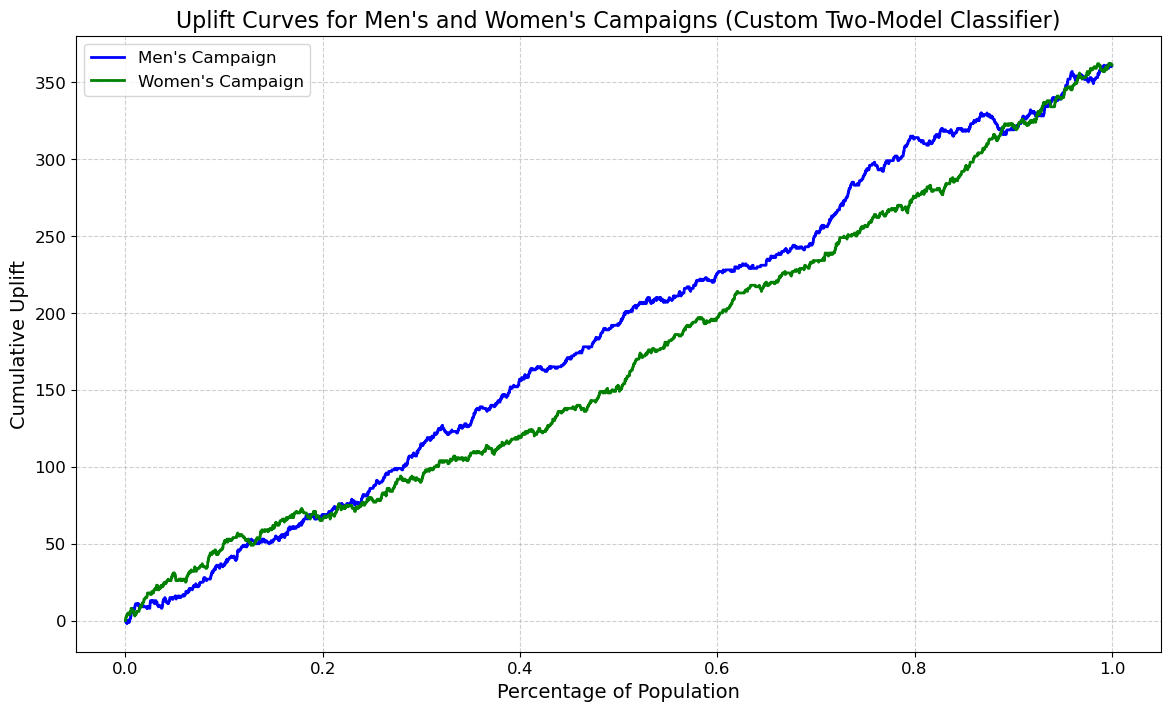

In [19]:
def plot_two_model_uplift(y_test, T_test, uplift_scores_two_model_mens, uplift_scores_two_model_womens):
    y_test = np.array(y_test)
    T_test = np.array(T_test)
    
    def cumulative_uplift(y_true, uplift_scores, treatment):
        sorted_indices = np.argsort(uplift_scores)[::-1]
        y_true_sorted = y_true[sorted_indices]
        treatment_sorted = treatment[sorted_indices]
        cumulative_uplift = np.cumsum(y_true_sorted * (treatment_sorted == 1)) - np.cumsum(y_true_sorted * (treatment_sorted == 0))
        return cumulative_uplift

    cumulative_uplift_mens = cumulative_uplift(y_test, uplift_scores_two_model_mens, T_test)
    cumulative_uplift_womens = cumulative_uplift(y_test, uplift_scores_two_model_womens, T_test)
    
    plt.figure(figsize=(14, 8))
    plt.plot(np.arange(len(cumulative_uplift_mens)) / len(cumulative_uplift_mens), cumulative_uplift_mens, label="Men's Campaign", color='blue', linewidth=2)
    plt.plot(np.arange(len(cumulative_uplift_womens)) / len(cumulative_uplift_womens), cumulative_uplift_womens, label="Women's Campaign", color='green', linewidth=2)
    plt.title('Uplift Curves for Men\'s and Women\'s Campaigns (Custom Two-Model Classifier)', fontsize=16)
    plt.xlabel('Percentage of Population', fontsize=14)
    plt.ylabel('Cumulative Uplift', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

plot_two_model_uplift(y_test, T_test, uplift_scores_two_model_mens, uplift_scores_two_model_womens)

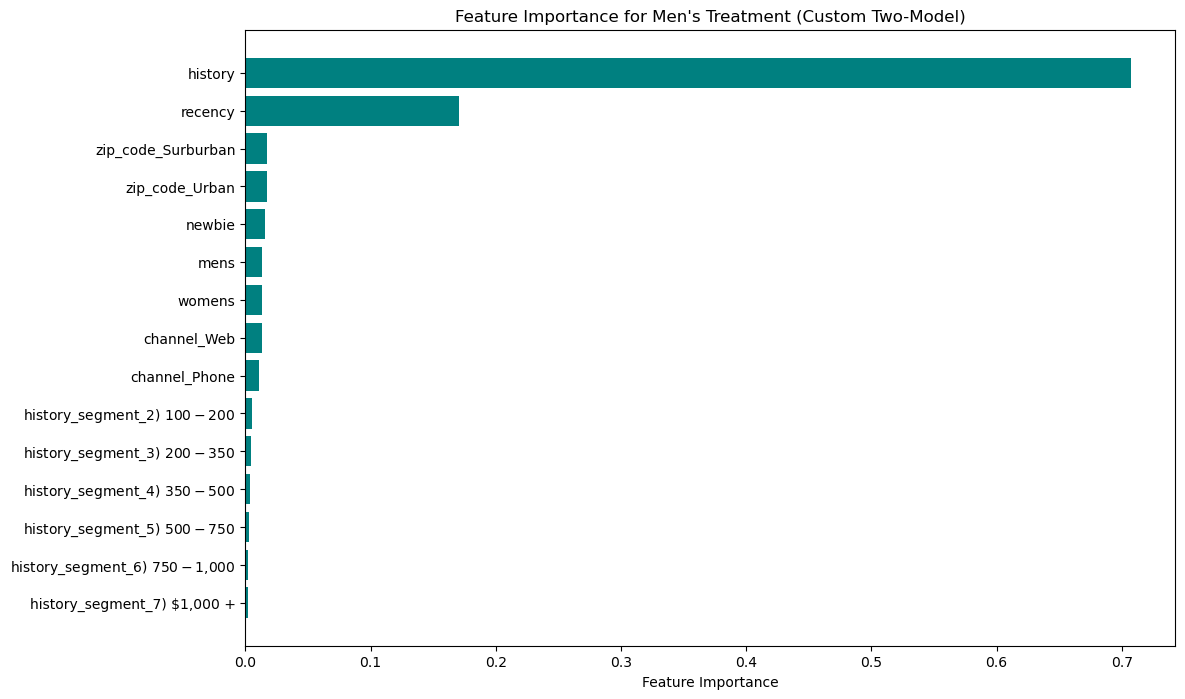

In [20]:
feature_importances_mens = model_treatment_mens.feature_importances_
feature_names = X_train.columns

indices_mens = np.argsort(feature_importances_mens)[::-1]

plt.figure(figsize=(12, 8))
plt.barh(range(X_train.shape[1]), feature_importances_mens[indices_mens], align="center", color='teal')
plt.yticks(range(X_train.shape[1]), feature_names[indices_mens])
plt.xlabel('Feature Importance')
plt.title("Feature Importance for Men's Treatment (Custom Two-Model)")
plt.gca().invert_yaxis()  
plt.show()


# The T-Learner Model (Gradient Boosting Classifier)
1. We implement the model and get its uplift score
2. Then we plot a graph to compare the men's and women's uplift score.
3. Then we draw a feature importance plot to explore the key attributes that affect this model the most.

In [21]:
def t_learner_uplift(X_train, y_train, T_train, X_test, y_test, T_test, treatment_value):
    X_train_treated = X_train[T_train == treatment_value]
    y_train_treated = y_train[T_train == treatment_value]
    X_train_control = X_train[T_train == 0]
    y_train_control = y_train[T_train == 0]

    model_treated = GradientBoostingClassifier(n_estimators=100, random_state=42)
    model_control = GradientBoostingClassifier(n_estimators=100, random_state=42)

    model_treated.fit(X_train_treated, y_train_treated)
    model_control.fit(X_train_control, y_train_control)

    treated_preds = model_treated.predict_proba(X_test)[:, 1]
    control_preds = model_control.predict_proba(X_test)[:, 1]

    uplift_scores_t_learner = treated_preds - control_preds

    is_treatment = (T_test == treatment_value).astype(int)
    uplift_score_t_learner = uplift_at_k(y_test, uplift_scores_t_learner, treatment=is_treatment, strategy='overall', k=0.3)
    
    return model_treated, model_control, uplift_scores_t_learner, uplift_score_t_learner

model_treated_mens, model_control_mens, uplift_scores_mens_t_learner, uplift_score_mens_t_learner = t_learner_uplift(X_train, y_train, T_train, X_test, y_test, T_test, treatment_value=1)
model_treated_womens, model_control_womens, uplift_scores_womens_t_learner, uplift_score_womens_t_learner = t_learner_uplift(X_train, y_train, T_train, X_test, y_test, T_test, treatment_value=2)

print(f'T-Learner Uplift for Men\'s at 30%: {uplift_score_mens_t_learner}')
print(f'T-Learner Uplift for Women\'s at 30%: {uplift_score_womens_t_learner}')

T-Learner Uplift for Men's at 30%: 0.06393165935471204
T-Learner Uplift for Women's at 30%: 0.030639070262695467


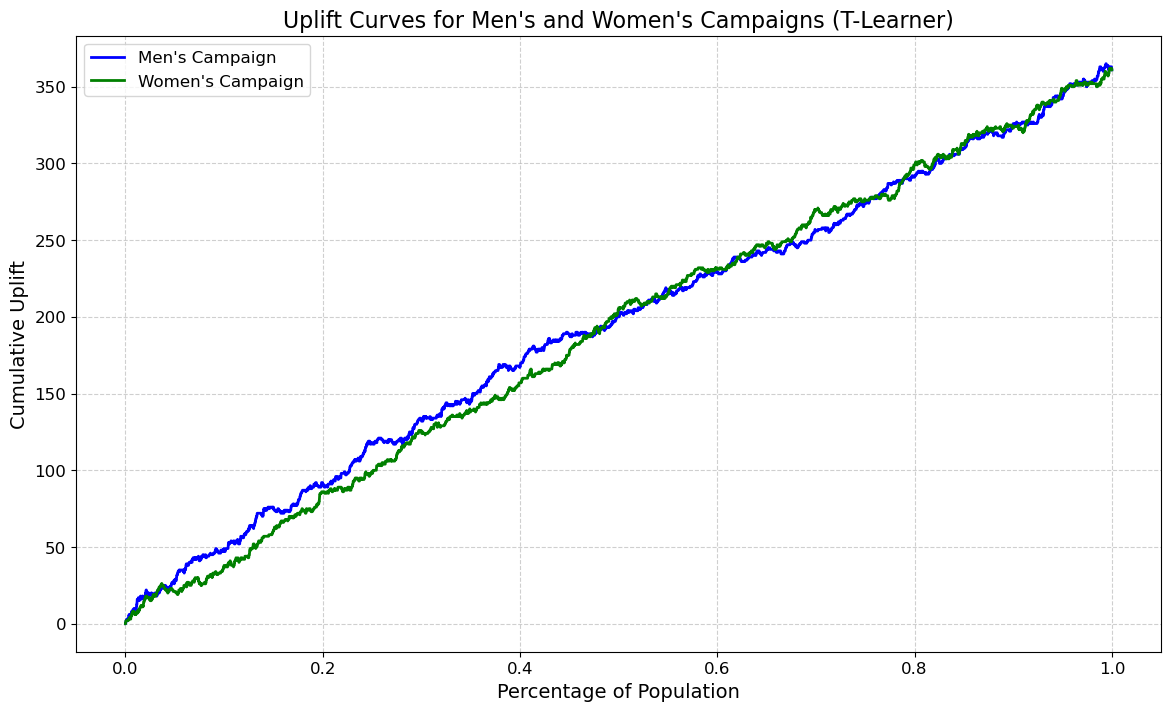

In [22]:
def plot_uplift_curves_t_learner(y_test, T_test, uplift_scores_mens_t_learner, uplift_scores_womens_t_learner):
    y_test = np.array(y_test)
    T_test = np.array(T_test)
    
    def cumulative_uplift(y_true, uplift_scores, treatment):
        sorted_indices = np.argsort(uplift_scores)[::-1]
        y_true_sorted = y_true[sorted_indices]
        treatment_sorted = treatment[sorted_indices]
        cumulative_uplift = np.cumsum(y_true_sorted * (treatment_sorted == 1)) - np.cumsum(y_true_sorted * (treatment_sorted == 0))
        return cumulative_uplift

    cumulative_uplift_mens_t_learner = cumulative_uplift(y_test, uplift_scores_mens_t_learner, T_test)
    cumulative_uplift_womens_t_learner = cumulative_uplift(y_test, uplift_scores_womens_t_learner, T_test)
    
    plt.figure(figsize=(14, 8))
    plt.plot(np.arange(len(cumulative_uplift_mens_t_learner)) / len(cumulative_uplift_mens_t_learner), cumulative_uplift_mens_t_learner, label="Men's Campaign", color='blue', linewidth=2)
    plt.plot(np.arange(len(cumulative_uplift_womens_t_learner)) / len(cumulative_uplift_womens_t_learner), cumulative_uplift_womens_t_learner, label="Women's Campaign", color='green', linewidth=2)
    plt.title('Uplift Curves for Men\'s and Women\'s Campaigns (T-Learner)', fontsize=16)
    plt.xlabel('Percentage of Population', fontsize=14)
    plt.ylabel('Cumulative Uplift', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

plot_uplift_curves_t_learner(y_test, T_test, uplift_scores_mens_t_learner, uplift_scores_womens_t_learner)

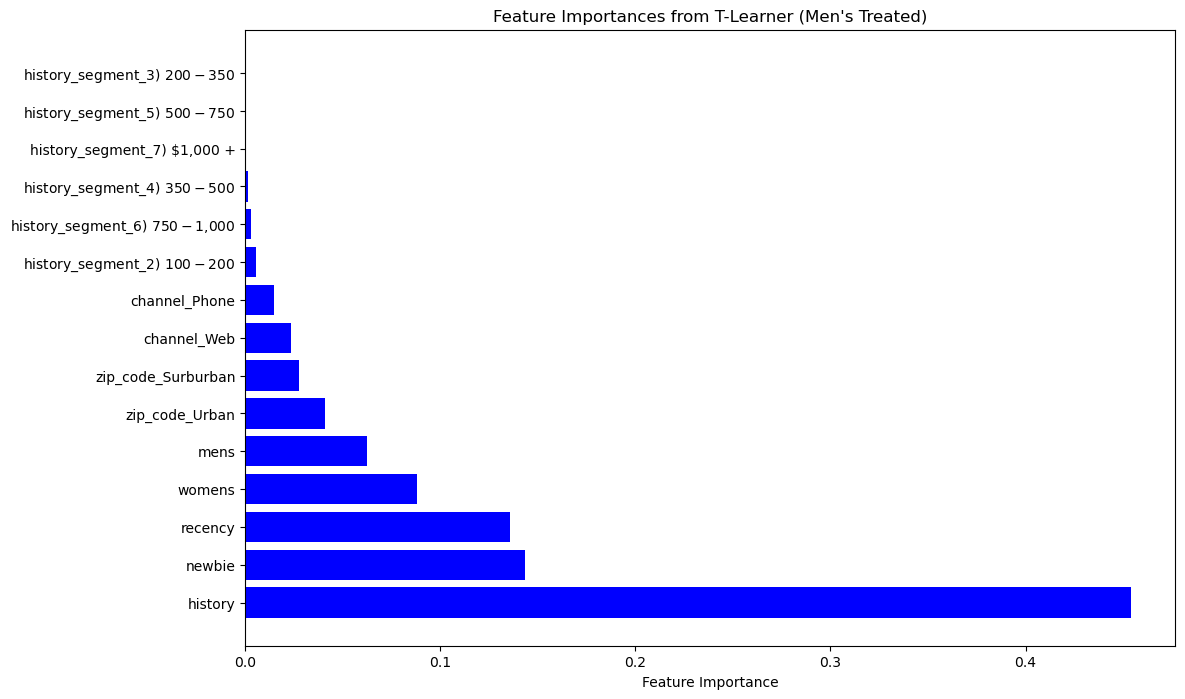

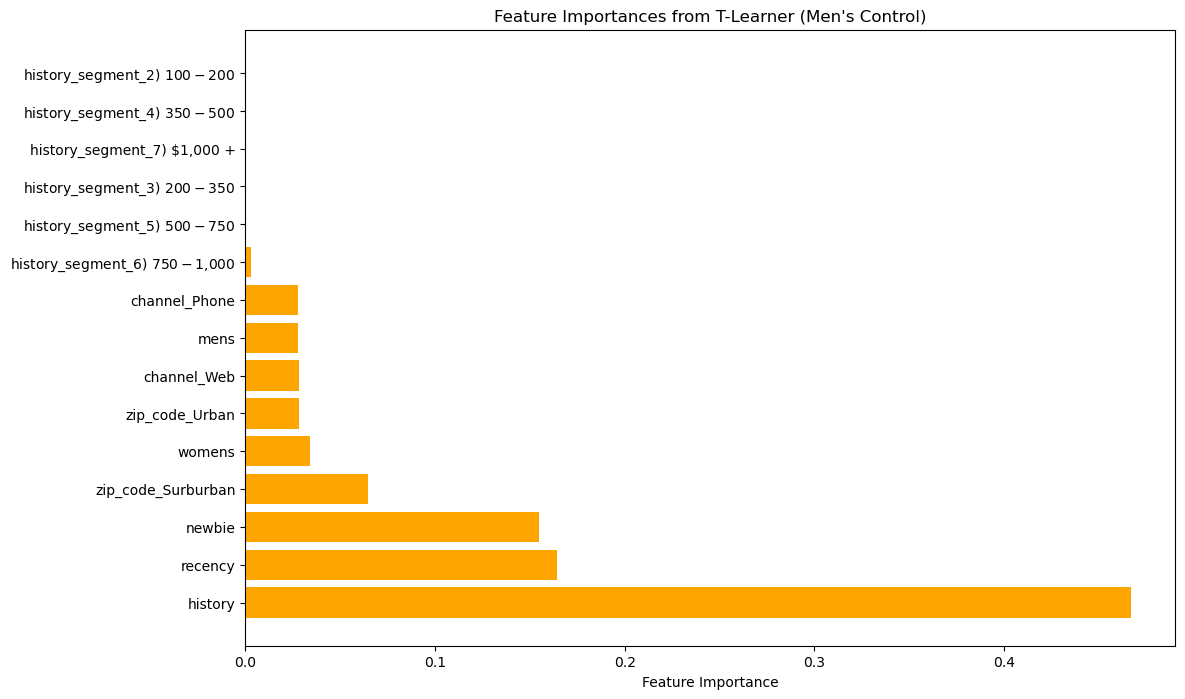

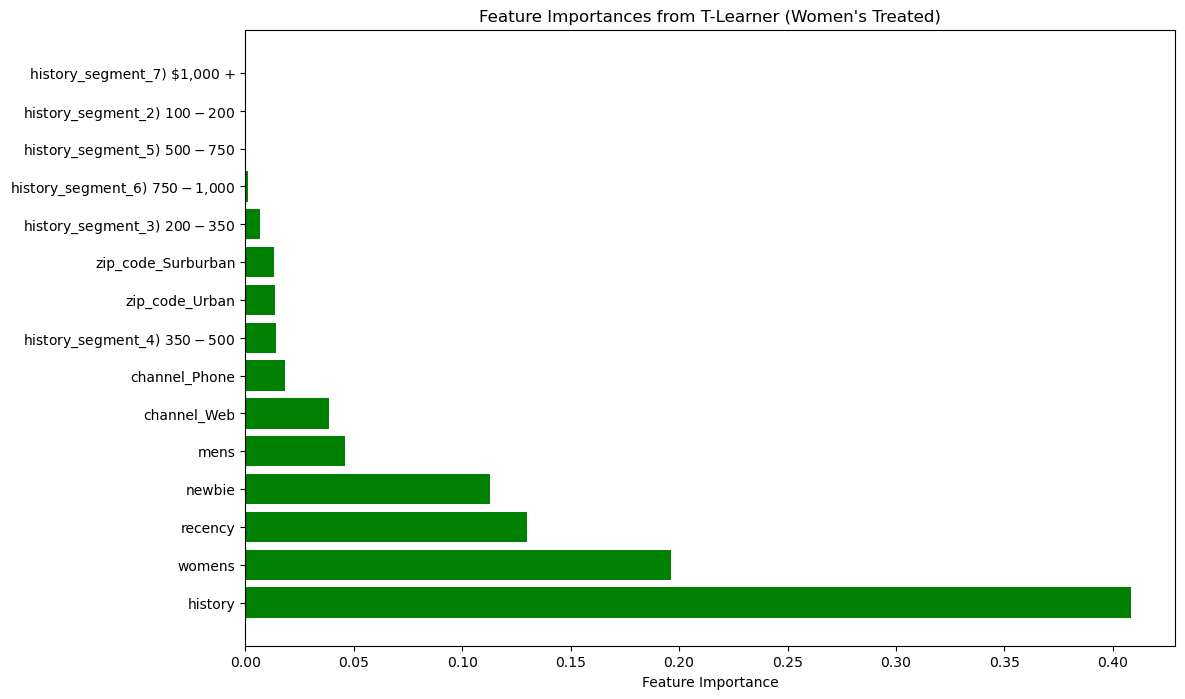

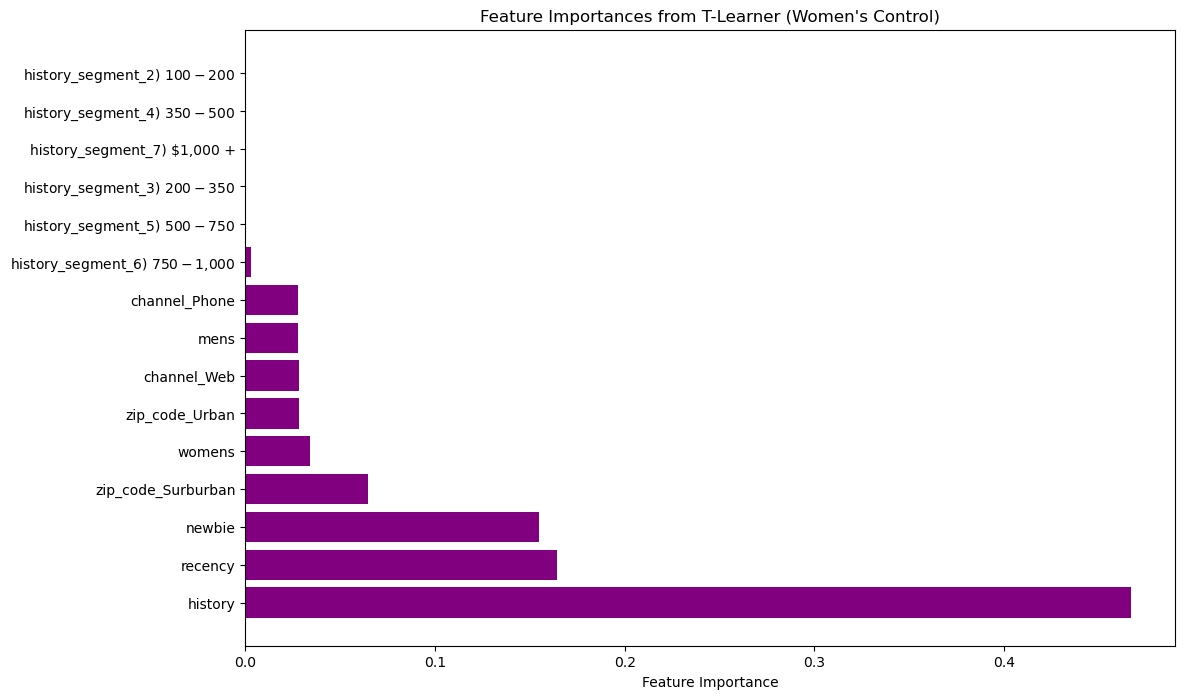

In [23]:
feature_importances_treated_mens = model_treated_mens.feature_importances_
feature_importances_control_mens = model_control_mens.feature_importances_
feature_names_t_learner = X_train.columns

indices_treated_mens = np.argsort(feature_importances_treated_mens)[::-1]
indices_control_mens = np.argsort(feature_importances_control_mens)[::-1]

plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_names_t_learner)), feature_importances_treated_mens[indices_treated_mens], align="center", color='blue')
plt.yticks(range(len(feature_names_t_learner)), np.array(feature_names_t_learner)[indices_treated_mens])
plt.xlabel('Feature Importance')
plt.title('Feature Importances from T-Learner (Men\'s Treated)')
plt.show()

plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_names_t_learner)), feature_importances_control_mens[indices_control_mens], align="center", color='orange')
plt.yticks(range(len(feature_names_t_learner)), np.array(feature_names_t_learner)[indices_control_mens])
plt.xlabel('Feature Importance')
plt.title('Feature Importances from T-Learner (Men\'s Control)')
plt.show()

feature_importances_treated_womens = model_treated_womens.feature_importances_
feature_importances_control_womens = model_control_womens.feature_importances_

indices_treated_womens = np.argsort(feature_importances_treated_womens)[::-1]
indices_control_womens = np.argsort(feature_importances_control_womens)[::-1]

plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_names_t_learner)), feature_importances_treated_womens[indices_treated_womens], align="center", color='green')
plt.yticks(range(len(feature_names_t_learner)), np.array(feature_names_t_learner)[indices_treated_womens])
plt.xlabel('Feature Importance')
plt.title('Feature Importances from T-Learner (Women\'s Treated)')
plt.show()

plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_names_t_learner)), feature_importances_control_womens[indices_control_womens], align="center", color='purple')
plt.yticks(range(len(feature_names_t_learner)), np.array(feature_names_t_learner)[indices_control_womens])
plt.xlabel('Feature Importance')
plt.title('Feature Importances from T-Learner (Women\'s Control)')
plt.show()

## Implementing Shap Values (for better Explanability)
How to Read a SHAP Summary Plot

A SHAP summary plot gives understanding about how each feature helps make the model's predictions:

<b> Vertical Axis: </b> Shows the features ordered by importance. Most significant ones are at the top.

<b> Horizontal Position: </b> Shows the SHAP value, which tells how much it changes prediction. Values on right side increase prediction, while values on left side decrease it.

<b> Color: </b> It shows the feature value. For example, red means high values and blue means low values. This is useful to understand how feature values affect predictions.

For example, if a feature's red points (high values) mostly appear on the right side, this suggests that higher values of that feature make the prediction go up.

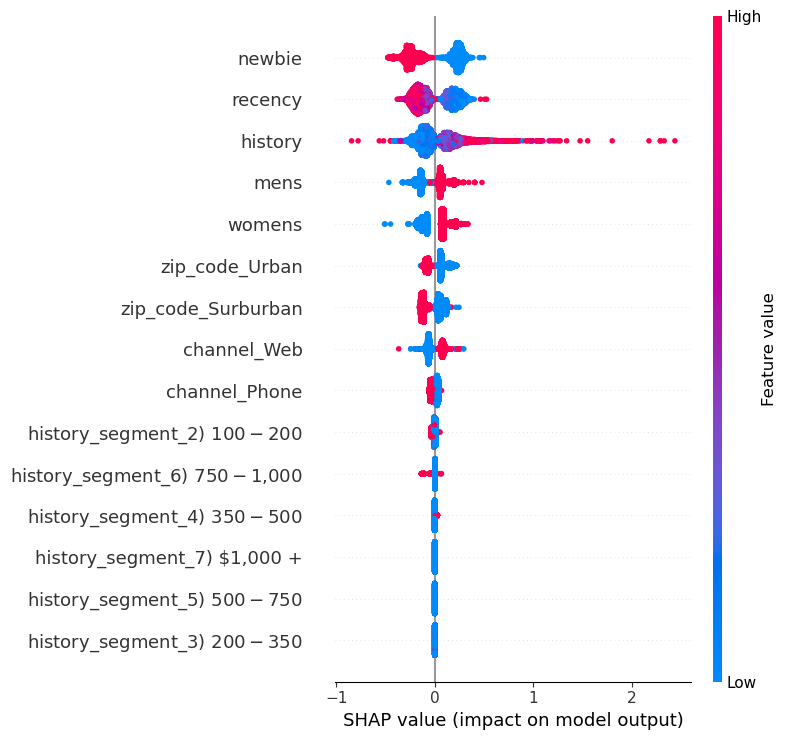

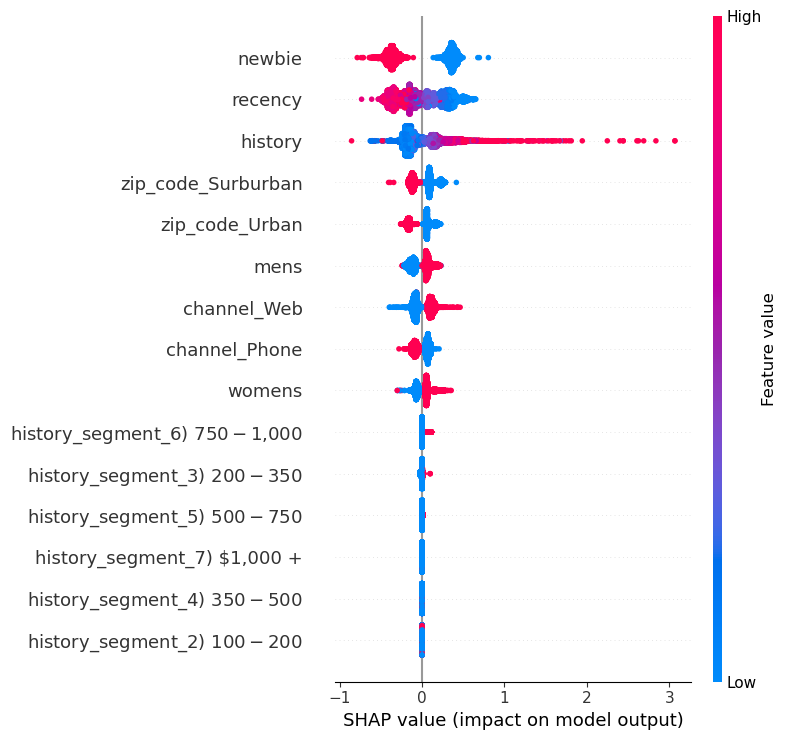

In [24]:
explainer_treated_mens = shap.TreeExplainer(model_treated_mens)
explainer_control_mens = shap.TreeExplainer(model_control_mens)

shap_values_treated_mens = explainer_treated_mens.shap_values(X_test)

shap_values_control_mens = explainer_control_mens.shap_values(X_test)

shap.summary_plot(shap_values_treated_mens, X_test, feature_names=X.columns)

shap.summary_plot(shap_values_control_mens, X_test, feature_names=X.columns)

# Comparing the Models
### 1. First we make a line graph comparing the uplift scores of all models in men's and women's email campaigns.
### 2. Then we compare the models based on their performance in a box plot to get a clear idea for our analysis

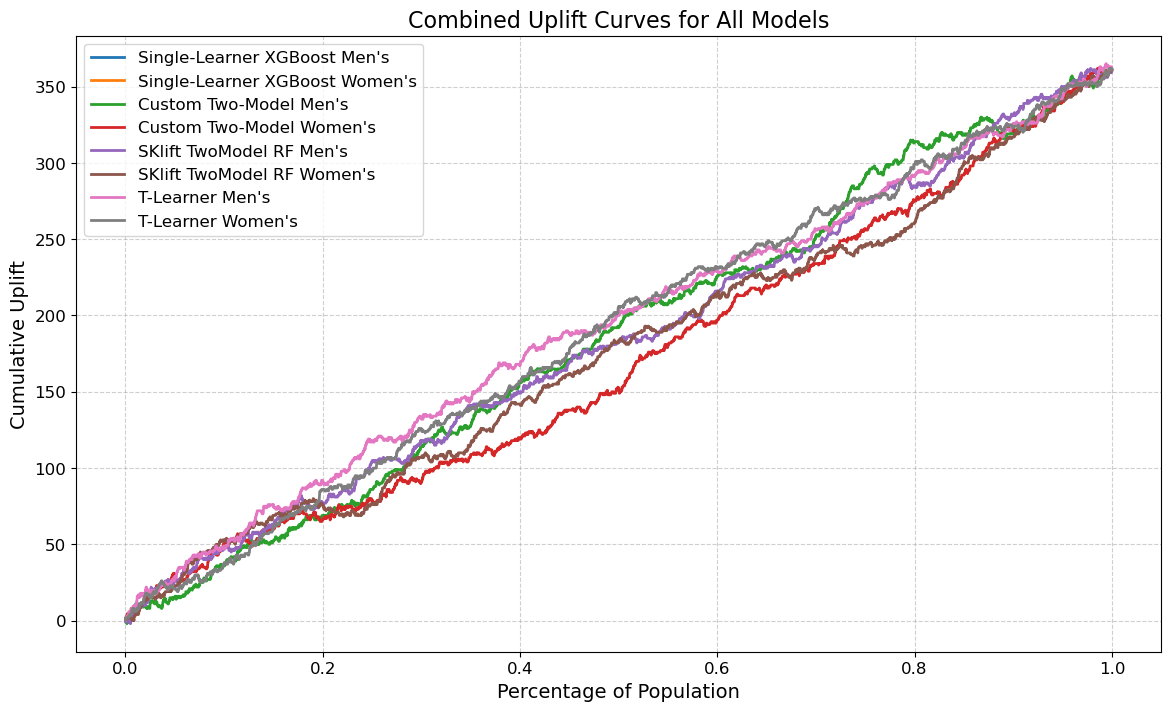

In [25]:
def plot_combined_uplift_curves(y_test, T_test, uplift_scores_dict):
    y_test = np.array(y_test)
    T_test = np.array(T_test)
    
    plt.figure(figsize=(14, 8))
    
    for model_name, uplift_scores in uplift_scores_dict.items():
        cumulative_uplift = cumulative_uplift_function(y_test, uplift_scores, T_test)
        plt.plot(np.arange(len(cumulative_uplift)) / len(cumulative_uplift), cumulative_uplift, label=model_name, linewidth=2)

    plt.title('Combined Uplift Curves for All Models', fontsize=16)
    plt.xlabel('Percentage of Population', fontsize=14)
    plt.ylabel('Cumulative Uplift', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

def cumulative_uplift_function(y_true, uplift_scores, treatment):
    sorted_indices = np.argsort(uplift_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]
    treatment_sorted = treatment[sorted_indices]
    cumulative_uplift = np.cumsum(y_true_sorted * (treatment_sorted == 1)) - np.cumsum(y_true_sorted * (treatment_sorted == 0))
    return cumulative_uplift

uplift_scores_dict = {
    "Single-Learner XGBoost Men's": uplift_score_single_mens,
    "Single-Learner XGBoost Women's": uplift_score_single_womens,
    "Custom Two-Model Men's": uplift_scores_two_model_mens,
    "Custom Two-Model Women's": uplift_scores_two_model_womens,
    "SKlift TwoModel RF Men's": uplift_scores_mens_rf,
    "SKlift TwoModel RF Women's": uplift_scores_womens_rf,
    "T-Learner Men's": uplift_scores_mens_t_learner,
    "T-Learner Women's": uplift_scores_womens_t_learner
}

plot_combined_uplift_curves(y_test, T_test, uplift_scores_dict)


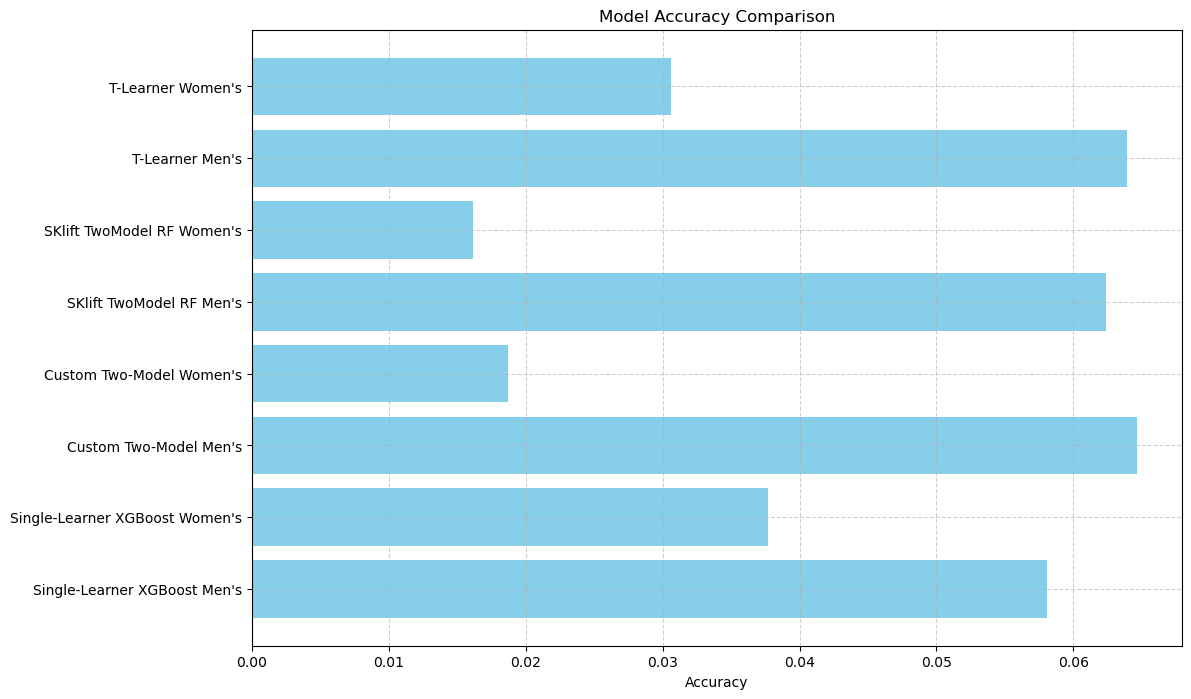

In [26]:
models = ['Single-Learner XGBoost Men\'s', 'Single-Learner XGBoost Women\'s', 
          'Custom Two-Model Men\'s', 'Custom Two-Model Women\'s', 
          'SKlift TwoModel RF Men\'s', 'SKlift TwoModel RF Women\'s',
          'T-Learner Men\'s', 'T-Learner Women\'s']

accuracies = [
    float(uplift_score_single_mens), float(uplift_score_single_womens), 
    float(uplift_score_two_model_mens), float(uplift_score_two_model_womens), 
    float(uplift_score_mens_rf), float(uplift_score_womens_rf), 
    float(uplift_score_mens_t_learner), float(uplift_score_womens_t_learner)
]

plt.figure(figsize=(12, 8))
plt.barh(models, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()